## Importar Librerias

In [3]:
!pip install darts --quiet
!pip install numpy pandas scikit-learn matplotlib tqdm darts lightgbm joblib --quiet

In [4]:
import numpy as np
import pandas as pd
import sklearn
import darts
import matplotlib.pyplot as plt
from darts.timeseries import TimeSeries
from darts.models import RegressionModel
from sklearn.linear_model import LinearRegression
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import Scaler, StaticCovariatesTransformer, MissingValuesFiller, InvertibleMapper
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.models.filtering.moving_average_filter import MovingAverageFilter
from datetime import datetime, timedelta

C:\Users\juana\PycharmProjects\tesis-umpe-supermarket-stock-prediction\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
train = pd.read_csv('train.csv',parse_dates=["date"])
test = pd.read_csv('test.csv',parse_dates=["date"])
oil = pd.read_csv('oil.csv',parse_dates=["date"]).rename(columns={"dcoilwtico": "oil_price"})
holidays = pd.read_csv('holidays_events.csv',parse_dates=["date"])
stores = pd.read_csv('stores.csv')
transactions = pd.read_csv('transactions.csv',parse_dates=["date"])

FileNotFoundError: [Errno 2] No such file or directory: 'train.csv'

In [4]:
train_merged = pd.merge(train, stores, on ='store_nbr')
train_merged = train_merged.sort_values(["store_nbr","family","date"])
train_merged = train_merged.astype({"store_nbr":'str', "family":'str', "city":'str',
                          "state":'str', "type":'str', "cluster":'str'})

display(train_merged.head())

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13
1782,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,Quito,Pichincha,D,13
3564,3564,2013-01-03,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13
5346,5346,2013-01-04,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13
7128,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,Quito,Pichincha,D,13


In [5]:
df_test_dropped = test.drop(['onpromotion'], axis=1)
df_test_sorted = df_test_dropped.sort_values(by=['store_nbr','family'])

display(df_test_sorted.head())

,id,date,store_nbr,family
0,3000888,2017-08-16,1,AUTOMOTIVE
1782,3002670,2017-08-17,1,AUTOMOTIVE
3564,3004452,2017-08-18,1,AUTOMOTIVE
5346,3006234,2017-08-19,1,AUTOMOTIVE
7128,3008016,2017-08-20,1,AUTOMOTIVE


In [6]:
family_list = train['family'].unique()
store_list = stores['store_nbr'].unique()
display(family_list)
display(store_list)

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54])

In [7]:
family_TS_dict = {}

for family in family_list:
    df_family = train_merged.loc[train_merged['family'] == family]

    list_of_TS_family = TimeSeries.from_group_dataframe(
                                df_family,
                                time_col="date",
                                group_cols=["store_nbr","family"],
                                static_cols=["city","state","type","cluster"],
                                value_cols="sales",
                                fill_missing_dates=True,
                                freq='D')
    for ts in list_of_TS_family:
            ts = ts.astype(np.float32)

    list_of_TS_family = sorted(list_of_TS_family, key=lambda ts: int(ts.static_covariates_values()[0,0]))
    family_TS_dict[family] = list_of_TS_family

<Axes: xlabel='date'>

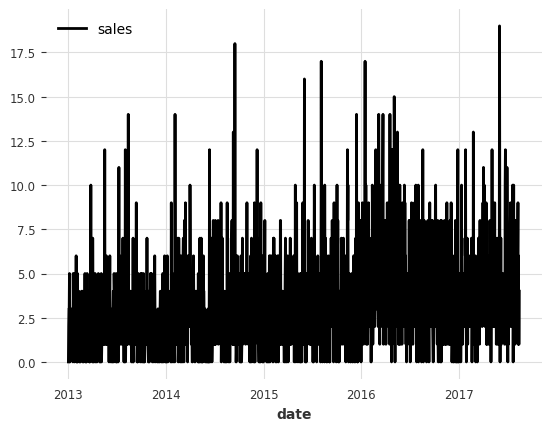

In [8]:
family_TS_dict['AUTOMOTIVE'][0].plot()

In [9]:
family_pipeline_dict = {}
family_TS_transformed_dict = {}

for key in family_TS_dict:
    train_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Fill NAs")
    static_cov_transformer = StaticCovariatesTransformer(verbose=False, transformer_cat = sklearn.preprocessing.OneHotEncoder(), name="Encoder")
    log_transformer = InvertibleMapper(np.log1p, np.expm1, verbose=False, n_jobs=-1, name="Log-Transform")
    train_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaling")

    train_pipeline = Pipeline([train_filler,
                             static_cov_transformer,
                             log_transformer,
                             train_scaler])

    training_transformed = train_pipeline.fit_transform(family_TS_dict[key])
    family_pipeline_dict[key] = train_pipeline
    family_TS_transformed_dict[key] = training_transformed

<Axes: xlabel='date'>

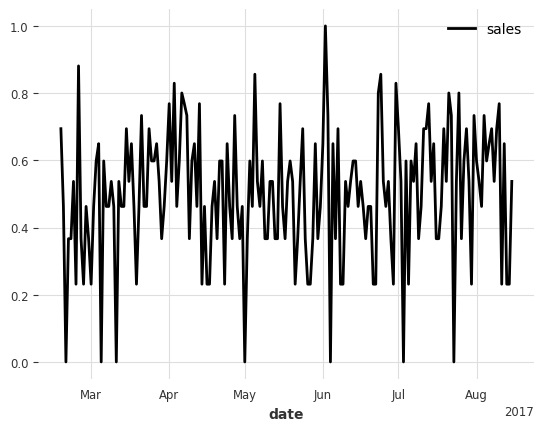

In [10]:
family_TS_transformed_dict['AUTOMOTIVE'][0][-180:].plot()

In [11]:

full_time_period = pd.date_range(start='2013-01-01', end='2017-08-31', freq='D')
year = datetime_attribute_timeseries(time_index = full_time_period, attribute="year")
month = datetime_attribute_timeseries(time_index = full_time_period, attribute="month")
day = datetime_attribute_timeseries(time_index = full_time_period, attribute="day")
dayofyear = datetime_attribute_timeseries(time_index = full_time_period, attribute="dayofyear")
weekday = datetime_attribute_timeseries(time_index = full_time_period, attribute="dayofweek")
weekofyear = datetime_attribute_timeseries(time_index = full_time_period, attribute="weekofyear")
timesteps = TimeSeries.from_times_and_values(times=full_time_period,
                                             values=np.arange(len(full_time_period)),
                                             columns=["linear_increase"])

time_cov = year.stack(month).stack(day).stack(dayofyear).stack(weekday).stack(weekofyear).stack(timesteps)
time_cov = time_cov.astype(np.float32)
time_cov_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaler")
time_cov_train, time_cov_val = time_cov.split_before(pd.Timestamp('20170816'))
time_cov_scaler.fit(time_cov_train)
time_cov_transformed = time_cov_scaler.transform(time_cov)
print(time_cov.components.values)

['year' 'month' 'day' 'dayofyear' 'dayofweek' 'weekofyear'
 'linear_increase']


In [12]:
# Oil Price
oil = TimeSeries.from_dataframe(oil,
                                time_col = 'date',
                                value_cols = ['oil_price'],
                                freq = 'D')

oil = oil.astype(np.float32)

# Transformar
oil_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Filler")
oil_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaler")
oil_pipeline = Pipeline([oil_filler, oil_scaler])
oil_transformed = oil_pipeline.fit_transform(oil)

# Moving Averages para Oil Price
oil_moving_average_7 = MovingAverageFilter(window=7)
oil_moving_average_28 = MovingAverageFilter(window=28)

oil_moving_averages = []

ma_7 = oil_moving_average_7.filter(oil_transformed).astype(np.float32)
ma_7 = ma_7.with_columns_renamed(col_names=ma_7.components, col_names_new="oil_ma_7")
ma_28 = oil_moving_average_28.filter(oil_transformed).astype(np.float32)
ma_28 = ma_28.with_columns_renamed(col_names=ma_28.components, col_names_new="oil_ma_28")
oil_moving_averages = ma_7.stack(ma_28)

Text(0.5, 1.0, 'Oil Price and Moving Averages')

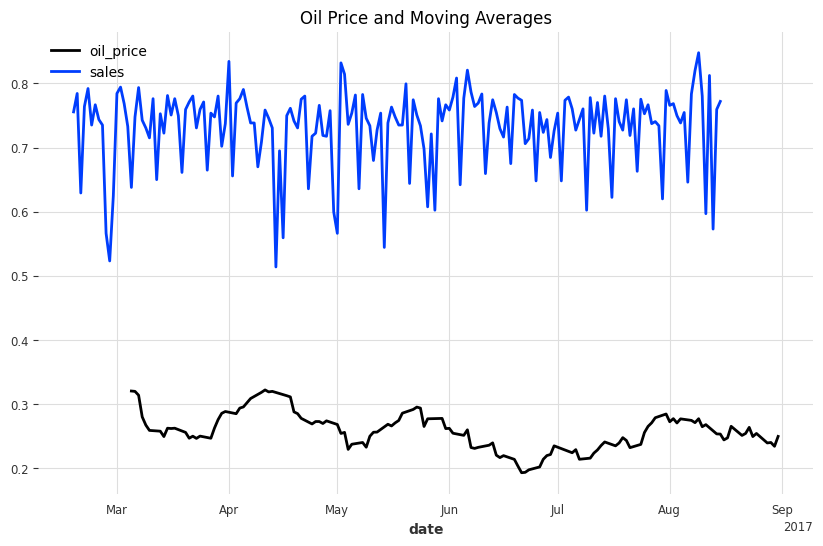

In [13]:
plt.figure(figsize=(10, 6))
oil_transformed[-180:].plot()
family_TS_transformed_dict['PERSONAL CARE'][0][-180:].plot()
plt.title("Oil Price and Moving Averages")

In [14]:

df_transactions = transactions
df_transactions.sort_values(["store_nbr","date"], inplace=True)

TS_transactions_list = TimeSeries.from_group_dataframe(
                                df_transactions,
                                time_col="date",
                                group_cols=["store_nbr"],
                                value_cols="transactions",
                                fill_missing_dates=True,
                                freq='D')

transactions_list = []


In [15]:
for ts in TS_transactions_list:
            series = TimeSeries.from_series(pd.Series(ts.values().flatten(), index=ts.time_index))
            series = series.astype(np.float32)
            transactions_list.append(series)

transactions_list[24] = transactions_list[24].slice(start_ts=pd.Timestamp('20130102'), end_ts=pd.Timestamp('20170815'))

<Axes: xlabel='date'>

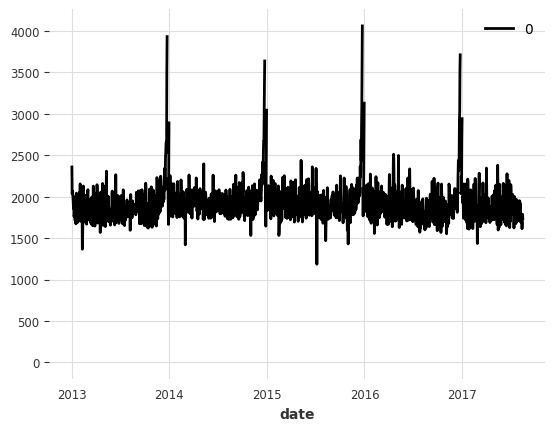

In [16]:
transactions_list[1].plot()

In [17]:


transactions_list_full = []

for ts in transactions_list:
    if ts.start_time() > pd.Timestamp('20130101'):
        end_time = (ts.start_time() - timedelta(days=1))
        delta = end_time - pd.Timestamp('20130101')
        zero_series = TimeSeries.from_times_and_values(
                              times=pd.date_range(start=pd.Timestamp('20130101'),
                              end=end_time, freq="D"),
                              values=np.zeros(delta.days+1))
        ts = zero_series.append(ts)
        ts = ts.with_columns_renamed(col_names=ts.components, col_names_new="transactions")
        transactions_list_full.append(ts)

transactions_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Filler")
transactions_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaler")

transactions_pipeline = Pipeline([transactions_filler, transactions_scaler])
transactions_transformed = transactions_pipeline.fit_transform(transactions_list_full)

In [18]:
df_promotion = pd.concat([train, test], axis=0)
df_promotion = df_promotion.sort_values(["store_nbr","family","date"])
df_promotion.tail()

family_promotion_dict = {}

for family in family_list:
    df_family = df_promotion.loc[df_promotion['family'] == family]

    list_of_TS_promo = TimeSeries.from_group_dataframe(
                                df_family,
                                time_col="date",
                                group_cols=["store_nbr","family"],
                                value_cols="onpromotion",
                                fill_missing_dates=True,
                                freq='D')

    for ts in list_of_TS_promo:
        ts = ts.astype(np.float32)

    family_promotion_dict[family] = list_of_TS_promo


In [19]:
from tqdm import tqdm

promotion_transformed_dict = {}

for key in tqdm(family_promotion_dict):
    promo_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Fill NAs")
    promo_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaling")

    promo_pipeline = Pipeline([promo_filler,
                             promo_scaler])

    promotion_transformed = promo_pipeline.fit_transform(family_promotion_dict[key])

  # Moving Averages for Promotion Family Dictionaries
    promo_moving_average_7 = MovingAverageFilter(window=7)
    promo_moving_average_28 = MovingAverageFilter(window=28)

    promotion_covs = []
    for ts in promotion_transformed:
        ma_7 = promo_moving_average_7.filter(ts)
        ma_7 = TimeSeries.from_series(pd.Series(ma_7.values().flatten(), index=ma_7.time_index))
        ma_7 = ma_7.astype(np.float32)
        ma_7 = ma_7.with_columns_renamed(col_names=ma_7.components, col_names_new="promotion_ma_7")
        ma_28 = promo_moving_average_28.filter(ts)
        ma_28 = TimeSeries.from_series(pd.Series(ma_28.values().flatten(), index=ma_28.time_index))
        ma_28 = ma_28.astype(np.float32)
        ma_28 = ma_28.with_columns_renamed(col_names=ma_28.components, col_names_new="promotion_ma_28")
        promo_and_mas = ts.stack(ma_7).stack(ma_28)
        promotion_covs.append(promo_and_mas)

    promotion_transformed_dict[key] = promotion_covs

100%|██████████| 33/33 [00:17<00:00,  1.85it/s]


In [20]:
df_holidays_events = holidays

In [21]:
def holiday_list(df_stores):

    listofseries = []

    for i in range(0,len(df_stores)):

            df_holiday_dummies = pd.DataFrame(columns=['date'])
            df_holiday_dummies["date"] = df_holidays_events["date"]

            df_holiday_dummies["national_holiday"] = np.where(((df_holidays_events["type"] == "Holiday") & (df_holidays_events["locale"] == "National")), 1, 0)

            df_holiday_dummies["earthquake_relief"] = np.where(df_holidays_events['description'].str.contains('Terremoto Manabi'), 1, 0)

            df_holiday_dummies["christmas"] = np.where(df_holidays_events['description'].str.contains('Navidad'), 1, 0)

            df_holiday_dummies["football_event"] = np.where(df_holidays_events['description'].str.contains('futbol'), 1, 0)

            df_holiday_dummies["national_event"] = np.where(((df_holidays_events["type"] == "Event") & (df_holidays_events["locale"] == "National") & (~df_holidays_events['description'].str.contains('Terremoto Manabi')) & (~df_holidays_events['description'].str.contains('futbol'))), 1, 0)

            df_holiday_dummies["work_day"] = np.where((df_holidays_events["type"] == "Work Day"), 1, 0)

            df_holiday_dummies["local_holiday"] = np.where(((df_holidays_events["type"] == "Holiday") & ((df_holidays_events["locale_name"] == df_stores['state'][i]) | (df_holidays_events["locale_name"] == df_stores['city'][i]))), 1, 0)

            listofseries.append(df_holiday_dummies)

    return listofseries

In [22]:
def remove_0_and_duplicates(holiday_list):

    listofseries = []

    for i in range(0,len(holiday_list)):

            df_holiday_per_store = list_of_holidays_per_store[i].set_index('date')

            df_holiday_per_store = df_holiday_per_store.loc[~(df_holiday_per_store==0).all(axis=1)]

            df_holiday_per_store = df_holiday_per_store.groupby('date').agg({'national_holiday':'max', 'earthquake_relief':'max',
                                   'christmas':'max', 'football_event':'max',
                                   'national_event':'max', 'work_day':'max',
                                   'local_holiday':'max'}).reset_index()

            listofseries.append(df_holiday_per_store)

    return listofseries

In [23]:
def holiday_TS_list_54(holiday_list):

    listofseries = []

    for i in range(0,54):

            holidays_TS = TimeSeries.from_dataframe(list_of_holidays_per_store[i],
                                        time_col = 'date',
                                        fill_missing_dates=True,
                                        fillna_value=0,
                                        freq='D')

            holidays_TS = holidays_TS.slice(pd.Timestamp('20130101'),pd.Timestamp('20170831'))
            holidays_TS = holidays_TS.astype(np.float32)
            listofseries.append(holidays_TS)

    return listofseries

In [24]:
list_of_holidays_per_store = holiday_list(stores)
list_of_holidays_per_store = remove_0_and_duplicates(list_of_holidays_per_store)
list_of_holidays_store = holiday_TS_list_54(list_of_holidays_per_store)

holidays_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Filler")
holidays_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaler")

holidays_pipeline = Pipeline([holidays_filler, holidays_scaler])
holidays_transformed = holidays_pipeline.fit_transform(list_of_holidays_store)

<Axes: xlabel='date'>

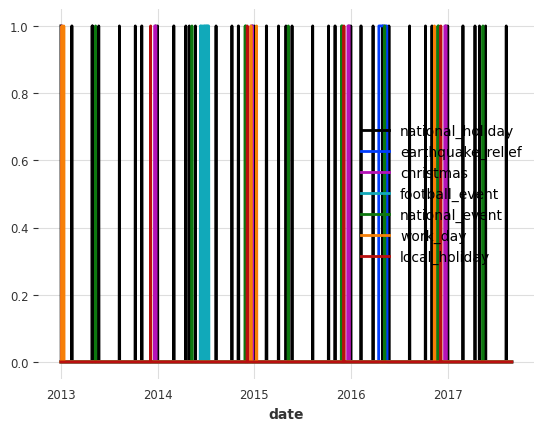

In [25]:
holidays_transformed[0].plot()

In [26]:
general_covariates = time_cov_transformed.stack(oil_transformed).stack(oil_moving_averages)

<Axes: xlabel='time'>

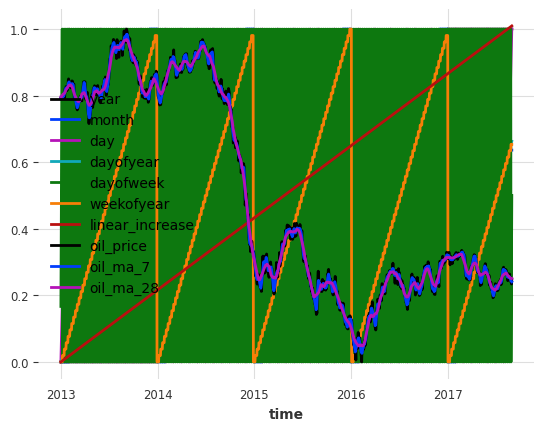

In [27]:
general_covariates.plot()

In [28]:
store_covariates_future = []

for store in range(0,len(store_list)):
    stacked_covariates = holidays_transformed[store].stack(general_covariates)
    store_covariates_future.append(stacked_covariates)

In [29]:
future_covariates_dict = {}

for key in tqdm(promotion_transformed_dict):

    promotion_family = promotion_transformed_dict[key]
    covariates_future = [promotion_family[i].stack(store_covariates_future[i]) for i in range(0,len(promotion_family))]

    future_covariates_dict[key] = covariates_future

100%|██████████| 33/33 [00:00<00:00, 33.67it/s]


In [30]:
from darts.models import LightGBMModel

LGBM_Models_Submission = {}

display("Training...")

for family in tqdm(family_list):

    sales_family = family_TS_transformed_dict[family]
    training_data = [ts for ts in sales_family]
    TCN_covariates = future_covariates_dict[family]
    train_sliced = [training_data[i].slice_intersect(TCN_covariates[i]) for i in range(0,len(training_data))]

    LGBM_Model_Submission = LightGBMModel(lags = 63,
                                        lags_future_covariates = (14,1),
                                        lags_past_covariates = [-16,-17,-18,-19,-20,-21,-22],
                                        output_chunk_length=1,
                                        random_state=2022,
                                        gpu_use_dp= "false",
                                        )

    LGBM_Model_Submission.fit(series=train_sliced,
                        future_covariates=TCN_covariates,
                        past_covariates=transactions_transformed)

    LGBM_Models_Submission[family] = LGBM_Model_Submission

'Training...'

  0%|          | 0/33 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.126408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43593
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 484
[LightGBM] [Info] Start training from score 0.461126


  3%|▎         | 1/33 [00:12<06:33, 12.30s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.138421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 28071
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 484
[LightGBM] [Info] Start training from score 0.026578


  6%|▌         | 2/33 [00:19<04:43,  9.13s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.160983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43474
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 484
[LightGBM] [Info] Start training from score 0.355426


  9%|▉         | 3/33 [00:32<05:28, 10.96s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.111348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50508
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 484
[LightGBM] [Info] Start training from score 0.773086


 12%|█▏        | 4/33 [00:46<05:57, 12.31s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.121285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 28197
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 439
[LightGBM] [Info] Start training from score 0.014777


 15%|█▌        | 5/33 [00:53<04:44, 10.14s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.112729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50478
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 484
[LightGBM] [Info] Start training from score 0.780724


 18%|█▊        | 6/33 [01:06<05:08, 11.42s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.135060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 46263
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 484
[LightGBM] [Info] Start training from score 0.314515


 21%|██        | 7/33 [01:18<04:54, 11.32s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.119135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50508
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 484
[LightGBM] [Info] Start training from score 0.776573


 24%|██▍       | 8/33 [01:32<05:05, 12.20s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.110962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50508
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 484
[LightGBM] [Info] Start training from score 0.788500


 27%|██▋       | 9/33 [01:46<05:07, 12.83s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.112516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50493
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 484
[LightGBM] [Info] Start training from score 0.783753


 30%|███       | 10/33 [02:00<05:05, 13.28s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.225852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 49353
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 484
[LightGBM] [Info] Start training from score 0.725482


 33%|███▎      | 11/33 [02:13<04:51, 13.26s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.629517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 49553
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 484
[LightGBM] [Info] Start training from score 0.525365


 36%|███▋      | 12/33 [02:30<04:59, 14.28s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.108819 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50508
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 484
[LightGBM] [Info] Start training from score 0.781579


 39%|███▉      | 13/33 [02:44<04:44, 14.21s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.404505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41898
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 484
[LightGBM] [Info] Start training from score 0.476225


 42%|████▏     | 14/33 [02:57<04:25, 13.96s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.439376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34592
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 484
[LightGBM] [Info] Start training from score 0.213819


 45%|████▌     | 15/33 [03:10<04:03, 13.50s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.155392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 49518
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 484
[LightGBM] [Info] Start training from score 0.368218


 48%|████▊     | 16/33 [03:22<03:43, 13.12s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.149098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 47271
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 484
[LightGBM] [Info] Start training from score 0.369973


 52%|█████▏    | 17/33 [03:34<03:24, 12.80s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.178091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27252
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 484
[LightGBM] [Info] Start training from score 0.129950


 55%|█████▍    | 18/33 [03:42<02:49, 11.27s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.142742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 49990
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 484
[LightGBM] [Info] Start training from score 0.504206


 58%|█████▊    | 19/33 [03:54<02:40, 11.44s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.138957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44607
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 484
[LightGBM] [Info] Start training from score 0.255837


 61%|██████    | 20/33 [04:03<02:21, 10.87s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.249626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 41935
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 484
[LightGBM] [Info] Start training from score 0.217584


 64%|██████▎   | 21/33 [04:15<02:12, 11.07s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.174811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 42505
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 484
[LightGBM] [Info] Start training from score 0.399493


 67%|██████▋   | 22/33 [04:28<02:08, 11.68s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.218151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 47928
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 484
[LightGBM] [Info] Start training from score 0.494947


 70%|██████▉   | 23/33 [04:41<02:00, 12.05s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.170942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40005
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 484
[LightGBM] [Info] Start training from score 0.229199


 73%|███████▎  | 24/33 [04:51<01:42, 11.41s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.124295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 49980
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 484
[LightGBM] [Info] Start training from score 0.759462


 76%|███████▌  | 25/33 [05:05<01:38, 12.34s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.679209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50387
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 484
[LightGBM] [Info] Start training from score 0.721247


 79%|███████▉  | 26/33 [05:22<01:36, 13.77s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.137653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 41475
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 484
[LightGBM] [Info] Start training from score 0.267552


 82%|████████▏ | 27/33 [05:32<01:14, 12.45s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.144371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43464
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 484
[LightGBM] [Info] Start training from score 0.316415


 85%|████████▍ | 28/33 [05:42<00:58, 11.72s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.195234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50218
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 484
[LightGBM] [Info] Start training from score 0.731955


 88%|████████▊ | 29/33 [05:55<00:48, 12.06s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.671017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 46533
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 484
[LightGBM] [Info] Start training from score 0.729706


 91%|█████████ | 30/33 [06:09<00:38, 12.84s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.141130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50508
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 484
[LightGBM] [Info] Start training from score 0.561345


 94%|█████████▍| 31/33 [06:21<00:24, 12.41s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.246215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 46005
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 484
[LightGBM] [Info] Start training from score 0.087959


 97%|█████████▋| 32/33 [06:29<00:11, 11.21s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.120631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43458
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 484
[LightGBM] [Info] Start training from score 0.512093


100%|██████████| 33/33 [06:41<00:00, 12.17s/it]


In [31]:
display("Predictions...")

LGBM_Forecasts_Families_Submission = {}

for family in tqdm(family_list):

    sales_family = family_TS_transformed_dict[family]
    training_data = [ts for ts in sales_family]
    LGBM_covariates = future_covariates_dict[family]
    train_sliced = [training_data[i].slice_intersect(TCN_covariates[i]) for i in range(0,len(training_data))]

    forecast_LGBM = LGBM_Models_Submission[family].predict(n=16,
                                         series=train_sliced,
                                         future_covariates=LGBM_covariates,
                                         past_covariates=transactions_transformed)

    LGBM_Forecasts_Families_Submission[family] = forecast_LGBM

'Predictions...'

  0%|          | 0/33 [00:00<?, ?it/s]WARNING:darts.models.forecasting.forecasting_model:`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.1

In [32]:
LGBM_Forecasts_Families_back_Submission = {}

for family in tqdm(family_list):

    LGBM_Forecasts_Families_back_Submission[family] = family_pipeline_dict[family].inverse_transform(LGBM_Forecasts_Families_Submission[family], partial=True)

100%|██████████| 33/33 [00:12<00:00,  2.60it/s]


In [33]:
for family in tqdm(LGBM_Forecasts_Families_back_Submission):
    for n in range(0,len(LGBM_Forecasts_Families_back_Submission[family])):
        if (family_TS_dict[family][n].univariate_values()[-21:] == 0).all():
            LGBM_Forecasts_Families_back_Submission[family][n] = LGBM_Forecasts_Families_back_Submission[family][n].map(lambda x: x * 0)

listofseries = []

for store in tqdm(range(0,54)):
    for family in family_list:
        oneforecast = pd.DataFrame(LGBM_Forecasts_Families_back_Submission[family][store].values(), index=LGBM_Forecasts_Families_back_Submission[family][store].time_index)
        oneforecast.columns = ['fcast']
        listofseries.append(oneforecast)

df_forecasts = pd.concat(listofseries)
df_forecasts.reset_index(drop=True, inplace=True)

# No Negative Forecasts
df_forecasts[df_forecasts < 0] = 0
forecasts_kaggle = pd.concat([df_test_sorted, df_forecasts.set_index(df_test_sorted.index)], axis=1)
forecasts_kaggle_sorted = forecasts_kaggle.sort_values(by=['id'])
forecasts_kaggle_sorted = forecasts_kaggle_sorted.drop(['date','store_nbr','family'], axis=1)
forecasts_kaggle_sorted = forecasts_kaggle_sorted.rename(columns={"fcast": "sales"})
forecasts_kaggle_sorted = forecasts_kaggle_sorted.reset_index(drop=True)

# Submission
submission_kaggle = forecasts_kaggle_sorted

100%|██████████| 54/54 [00:00<00:00, 453.86it/s]


In [34]:
submission_kaggle.head()

,id,sales
0,3000888,3.137218
1,3000889,0.000000
2,3000890,3.962451
3,3000891,2276.543092
4,3000892,0.039745


In [35]:
submission_kaggle.to_csv('submission.csv', index=False)